In [1]:
import importlib

import settings
import VPINN_tri_final
import mesh_lib

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights
import os 

importlib.reload(settings)
importlib.reload(mesh_lib)
importlib.reload(VPINN_tri_final)

from settings import *
from mesh_lib import *
from VPINN_tri_final import *
#tf.config.run_functions_eagerly(True)


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-11-25 00:41:24.520784: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 00:41:24.522249: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 00:41:24.559723: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 00:41:24.560379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 00:41:25.169236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

settings_lib imported 
interpolator_lib imported
mesh_lib imported
settings_lib imported 
mesh_lib imported


In [2]:
#to do
#error 
#seed 
#writing stuff to a csv file 



degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


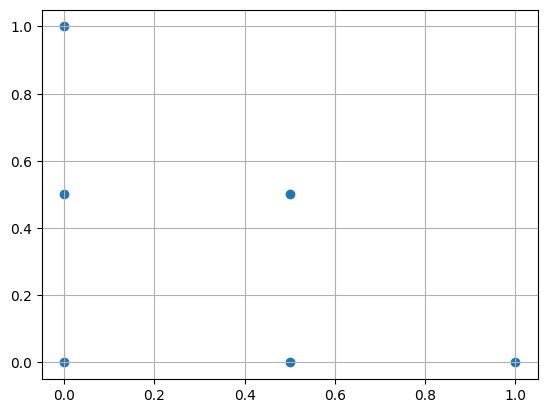

In [3]:
basis=interpolator(2,False,False,points=None)

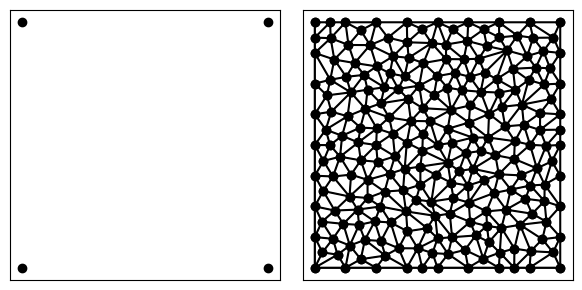

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr



# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A,'qnea0.004')

tr.compare(plt, A, B)

In [5]:

#edges flipping 

for i in range(len(B['edges'])):
    ii=B['edges'][i][0]
    jj=B['edges'][i][1]

    if ii>jj:
            B['edges'][i][0],B['edges'][i][1]=B['edges'][i][1],B['edges'][i][0]

#tr.compare(plt, A, B)



In [6]:

#util functions

def get_triangle_edges(triangle_vertices,edges):
    triangle_edges = []
 

    keep=np.zeros((3,),dtype=np.int64)

    for i in range(3):
        ii=triangle_vertices[i].copy()
        jj=triangle_vertices[(i + 1) % 3].copy()
        

        if(ii>jj):
            edge=np.array([jj,ii])
        else:
            edge=np.array([ii,jj])

        index= np.where(np.all(edges == edge, axis=1))[0][0]
        
        triangle_edges.append(index)

        if ii>jj:
            keep[i]=1

    triangle_edges=np.array(triangle_edges)
        
    return keep,triangle_edges

In [7]:
#flipping part + edges
l=[]
temp=[]
for triangle in B['triangles']:
    keep,t=get_triangle_edges(triangle,B['edges'])
    l.append(keep)
    temp.append(t)



keep=np.asarray(l)
edges_index_inside_triangle=np.asarray(temp)

In [8]:
B['keep']=keep
B['edges_index_inside_triangle']=edges_index_inside_triangle

In [9]:
B.keys()

dict_keys(['vertices', 'vertex_markers', 'triangles', 'neighbors', 'edges', 'edge_markers', 'keep', 'edges_index_inside_triangle'])

In [10]:
print(B['edges_index_inside_triangle'][0][0])

0


In [11]:
#exp
n_vertices=len(B['vertices'])
n_traingles=len(B['triangles'])
n_edges=len(B['edges'])

n_inside_edge=basis.n_inside_edge
n_inside=basis.n_inside

vertices_contribution=np.zeros((n_vertices,1))
edges_contribution=np.zeros((n_edges,n_inside_edge))
inside_contribution=np.zeros((n_traingles,n_inside))




for index,triangle in enumerate(B['triangles']):


    if (B['vertex_markers'][triangle[0]]==0):
            vertices_contribution[triangle[0]]=1
    else:
          vertices_contribution[triangle[0]]=2

    if (B['vertex_markers'][triangle[1]]==0):
            vertices_contribution[triangle[1]]=1
    else:
          vertices_contribution[triangle[1]]=2    

    if (B['vertex_markers'][triangle[2]]==0):
            vertices_contribution[triangle[2]]=1
    else:
          vertices_contribution[triangle[2]]=2
    

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][0]]==0):
           
           edges_contribution[B['edges_index_inside_triangle'][index][0]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][1]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][1]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][2]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][2]]+=3      




    
                                   

In [12]:
def find_h(mesh):
    h_max=-1
    h_min=100
    for edges in mesh['edges']:
        vertices=mesh['vertices'][edges]
        h_max=max(h_max,np.sqrt((vertices[0,0]-vertices[1,0])**2 +(vertices[0,1]-vertices[1,1])**2))
        h_min=min(h_min,np.sqrt((vertices[0,0]-vertices[1,0])**2 +(vertices[0,1]-vertices[1,1])**2))
    return h_max,h_min

In [13]:
tfk=tf.keras
tfkl=tf.keras.layers

In [14]:
model = tfk.models.Sequential()
model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer="glorot_uniform",dtype=tf.float64,use_bias=False))

In [15]:
print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 10        
                                                                 
Total params: 370 (2.89 KB)
Trainable params: 370 (2.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
(None, 2)
(None, 1)


In [16]:
from settings import *
N_tests = 2
N_elements = [5, 5]
params = {'scheme': 'VPINNs',
            'NN_struct': [2] + [5] * 3 + [1],
            'var_form': 1,
            'n_elements': tuple(N_elements),
            'n_test': [N_elements[0]*[N_tests], N_elements[1]*[N_tests]],
            'n_quad': 50,
            'n_bound': 80, # for every edge 
            'n_residual': 100,
            'domain': ((0.0, 1.0), (0.0, 1.0)),
            'Opt_Niter': 15000 + 1,
            'delta_test': 0.01,
            'N_test':N_tests}





758
degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


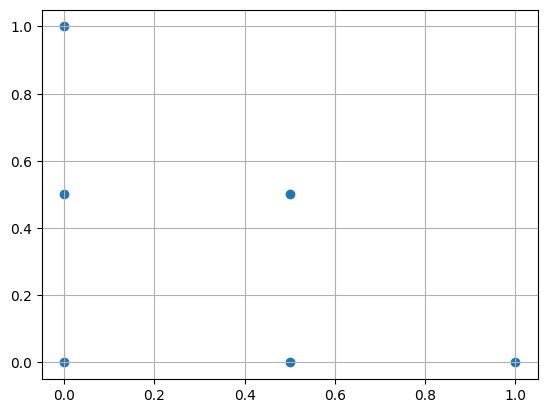

degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


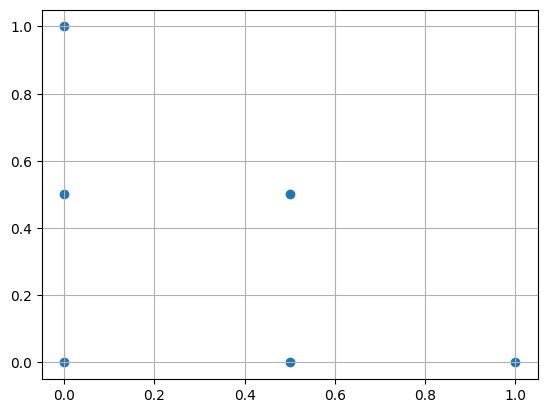

In [17]:
vp=VPINN(pb,params,B,model)

In [18]:
tf.reduce_mean(tf.square(model(vp.boundary_points) - vp.u_bound_exact))

<tf.Tensor: shape=(), dtype=float64, numpy=2.251935312734182>

In [19]:
_,c,J,B_D,B_DD=vp.b.change_of_coordinates(vp.mesh['vertices'][vp.mesh['triangles'][0]])

t=np.array(vp.grad_test)[0]

print((B_D@t))
print()
xy_quad_element=(B_D@ vp.grad_test)




[[ -9.27674782  -6.25341287  -2.03294694   1.77341156  -5.64402607
   -3.46728517  -0.42863384   2.31186841  -0.90433866   0.16783342
    1.66454674   3.01440422   2.72838309   2.95396111   3.26885984
    3.55286106]
 [-42.7271645  -28.8021843   -9.36341702   8.16804004 -25.99544959
  -15.96974143  -1.97421649  10.64808311  -4.16523412   0.77301293
    7.66662669  13.88384674  12.56648079  13.6054558   15.05582722
   16.36388981]]



In [20]:

w_quad = tf.concat([vp.w_quad.T, tf.ones_like(vp.w_quad.T)], axis=0)


In [21]:
#works with 0.004 with h =0.119 397 triangles 

print(n_traingles)
print(find_h(B)) #biggest and smaller of the edges 
history=vp.train(1000)



397
(0.12851082157772026, 0.05582723412933276)
Iteration: 0 loss: 2.2654693232 time: 65.43141579627991
Iteration: 10 loss: 0.2891879247 time: 0.26767706871032715
Iteration: 20 loss: 0.2372052912 time: 0.28343772888183594
Iteration: 30 loss: 0.2286607199 time: 0.2970120906829834
Iteration: 40 loss: 0.2255171618 time: 0.3565552234649658
Iteration: 50 loss: 0.2240815296 time: 0.3093912601470947
Iteration: 60 loss: 0.2222607752 time: 0.28473830223083496
Iteration: 70 loss: 0.2200444154 time: 0.2770709991455078
Iteration: 80 loss: 0.2169093328 time: 0.2665433883666992
Iteration: 90 loss: 0.2119762586 time: 0.2764723300933838
Iteration: 100 loss: 0.2033530780 time: 0.2963860034942627
Iteration: 110 loss: 0.1880681693 time: 0.3335273265838623
Iteration: 120 loss: 0.1645476493 time: 0.356264591217041
Iteration: 130 loss: 0.1361129837 time: 0.3741443157196045
Iteration: 140 loss: 0.1080830647 time: 0.4595670700073242
Iteration: 150 loss: 0.0838168348 time: 0.4863626956939697
Iteration: 160 loss

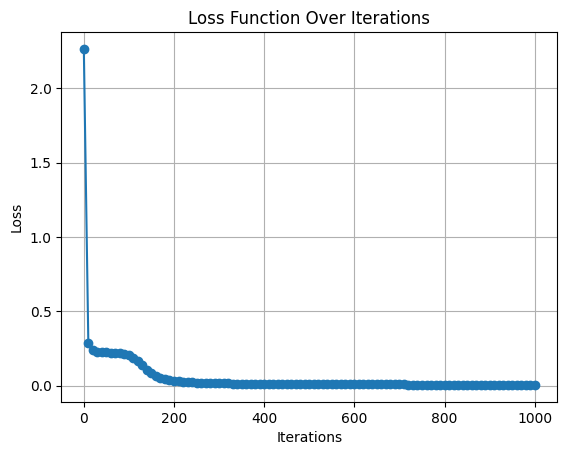

In [22]:
iterations = range(0, len(history) * 10, 10)  # Assuming losses are provided every 10 iterations

plt.plot(iterations, history, marker='o')
plt.title('Loss Function Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

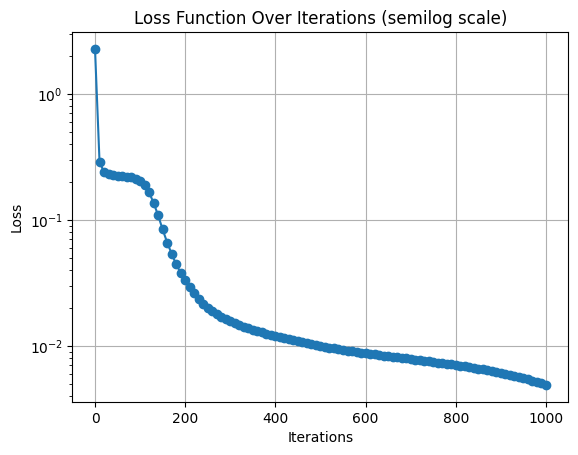

In [23]:
plt.semilogy(iterations, history, marker='o')
plt.title('Loss Function Over Iterations (semilog scale)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [24]:
vp.u_NN(1.0,2.0)

-0.7223257639616544

In [25]:
x=np.linspace(0,1,100,dtype=np.float32)



def u_exact(x,y):

    return np.cos(2*np.pi*x)*np.sin(2*np.pi*y)


eval_exact=[u_exact(x[i],0.85) for i in range(len(x))]

eval_net=[vp.u_NN(x[i],0.85) for i in range(len(x))]

eval_exact=np.array(eval_exact)
eval_net=np.array(eval_net)

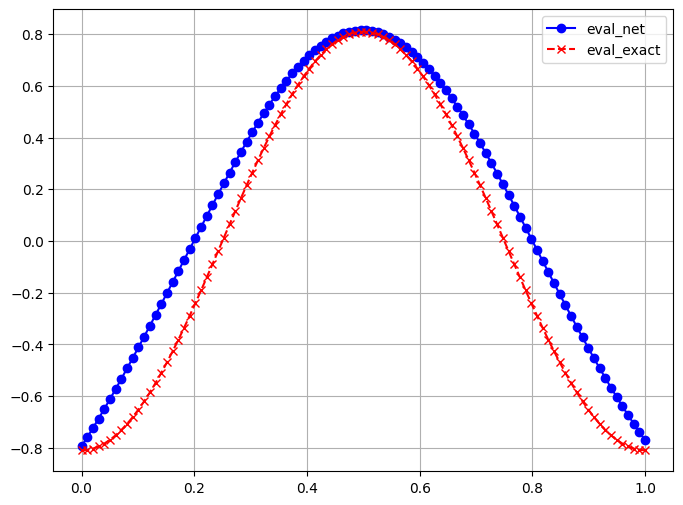

In [26]:
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the data
plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
plt.grid()
plt.legend()

#if you want reproducibility put a seed


In [27]:
## Add surface plot
import numpy as np
x=np.linspace(0,1,50,dtype=np.float32)
XX,YY = np.meshgrid(x,x)
xx = XX.flatten()
yy = YY.flatten()

X = np.vstack((xx,yy)).transpose()
print(X)
Z = [vp.u_NN(x[0],x[1]) for x in X]

[[0.         0.        ]
 [0.02040816 0.        ]
 [0.04081633 0.        ]
 ...
 [0.9591837  1.        ]
 [0.97959185 1.        ]
 [1.         1.        ]]


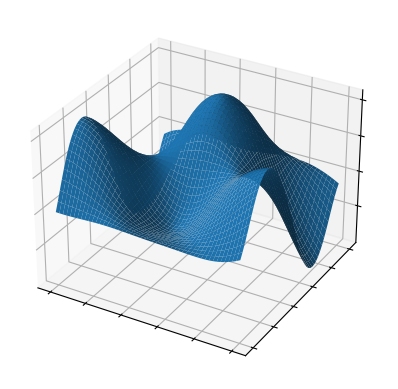

Text(0.5, 0.92, 'Original Code')

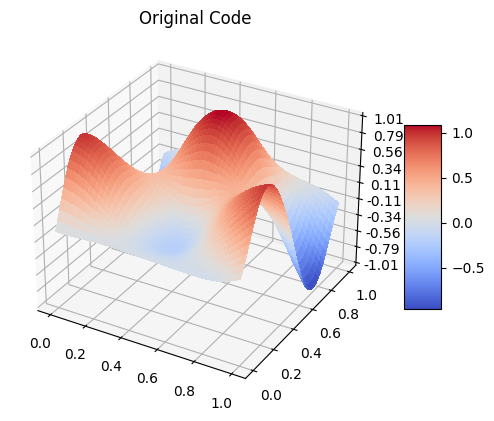

In [28]:
# Plot the surface
z = np.array(Z).flatten().reshape((50,50))
# z = np.reshape(z, (50,50))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(XX, YY, z, vmin=z.min() * 2)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(XX, YY, z, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Original Code')

In [29]:
#integration
from scipy.integrate import dblquad
integral,error=dblquad(lambda x,y: (u_exact(x,y)-vp.u_NN(x,y))**2, 0.0, 1.0,0.0, 1.0)

L2_error=np.sqrt(integral)
print(L2_error,error)

0.3252837474876639 6.432846571830658e-09


In [30]:

indices = tf.constant([[[triangle[0],1]], [[triangle[1],1]], [[triangle[2],1]]])


In [31]:
print(vp.NN.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float64, numpy=
array([[-0.07861294, -0.66735004, -0.55403852,  0.2639112 , -0.84657028,
        -0.69620162, -0.42701118,  0.18288903, -0.89343152,  0.247898  ],
       [-0.67650693, -0.34794528, -0.76533674, -0.20921675,  0.57062705,
         0.54810292, -0.38344808,  0.72079438, -0.2111834 ,  0.01968962]])>, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float64, numpy=
array([ 0.34353404, -0.29914797,  0.69297133,  0.20495068,  0.1432451 ,
       -0.41489181, -0.44809107, -0.56554111, -0.33575979, -0.41923891])>, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float64, numpy=
array([[ 1.19277842e+00,  5.97412946e-01,  6.99686574e-01,
         3.72479188e-01,  8.15831717e-02, -4.41403414e-02,
         1.74120868e-01, -8.13417328e-01, -1.59285224e-01,
         9.05234252e-01],
       [ 3.34264489e-01, -8.54809252e-02,  3.40140297e-01,
         6.10227782e-01, -3.11313871e-01,  4.26604280e-01,
         3.47381202e-01, -2.45972465e

In [32]:
tensor = tf.constant([[1, 1,1, 1]])    # tf.rank(tensor) == 2
indices = [[0,0]]           # num_updates == 2, index_depth == 2
updates = [5]                    # num_updates == 2
print(tf.tensor_scatter_nd_update(tensor, indices, updates))

print(vp.F_total_edges)


tf.Tensor([[5 1 1 1]], shape=(1, 4), dtype=int32)
tf.Tensor(
[[ 4.65427415e-02]
 [ 1.36982433e-02]
 [ 6.32305956e-02]
 [-5.65279741e-02]
 [ 3.70298452e-03]
 [ 1.40974450e-02]
 [-2.95951942e-01]
 [-2.50727470e-01]
 [-2.34739702e-01]
 [-1.09592596e-01]
 [-1.15607724e-01]
 [-1.54539040e-01]
 [ 0.00000000e+00]
 [ 3.03781417e-01]
 [ 2.64486075e-01]
 [ 1.67353087e-03]
 [-4.84725318e-02]
 [-4.30654387e-02]
 [-2.07094537e-02]
 [-5.52192814e-02]
 [-7.70027042e-02]
 [-1.74587172e-01]
 [-1.38241094e-01]
 [-1.46492206e-01]
 [-3.15082605e-01]
 [-2.43230967e-01]
 [-3.06473842e-01]
 [ 5.60473112e-02]
 [ 1.16133518e-01]
 [ 9.53374362e-02]
 [ 2.47077889e-02]
 [ 3.74348404e-03]
 [-1.76092326e-02]
 [ 2.14195656e-01]
 [ 2.25375151e-01]
 [ 2.39524475e-01]
 [ 1.14717829e-02]
 [ 3.86987679e-02]
 [ 2.10666195e-02]
 [ 1.00332953e-02]
 [-3.89182139e-04]
 [-1.44338276e-01]
 [-1.30771721e-01]
 [ 2.50427457e-01]
 [ 2.23114976e-01]
 [ 2.64546531e-01]
 [ 0.00000000e+00]
 [-3.45860541e-01]
 [ 2.14255190e-02]
 [-1.932

In [33]:
vp.boundary_points

<tf.Tensor: shape=(320, 2), dtype=float64, numpy=
array([[0.    , 0.    ],
       [0.0125, 0.    ],
       [0.025 , 0.    ],
       [0.0375, 0.    ],
       [0.05  , 0.    ],
       [0.0625, 0.    ],
       [0.075 , 0.    ],
       [0.0875, 0.    ],
       [0.1   , 0.    ],
       [0.1125, 0.    ],
       [0.125 , 0.    ],
       [0.1375, 0.    ],
       [0.15  , 0.    ],
       [0.1625, 0.    ],
       [0.175 , 0.    ],
       [0.1875, 0.    ],
       [0.2   , 0.    ],
       [0.2125, 0.    ],
       [0.225 , 0.    ],
       [0.2375, 0.    ],
       [0.25  , 0.    ],
       [0.2625, 0.    ],
       [0.275 , 0.    ],
       [0.2875, 0.    ],
       [0.3   , 0.    ],
       [0.3125, 0.    ],
       [0.325 , 0.    ],
       [0.3375, 0.    ],
       [0.35  , 0.    ],
       [0.3625, 0.    ],
       [0.375 , 0.    ],
       [0.3875, 0.    ],
       [0.4   , 0.    ],
       [0.4125, 0.    ],
       [0.425 , 0.    ],
       [0.4375, 0.    ],
       [0.45  , 0.    ],
       [0.4625, 0.    ],


In [34]:
a=tf.constant([1.0 ,2.0])


print(a)



tf.Tensor([1. 2.], shape=(2,), dtype=float32)


In [35]:
b=tf.Variable([1.0 ,2.0])

print(b)

b[0].assign(6.0)

print(b)


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([6., 2.], dtype=float32)>


In [36]:
x=tf.constant(6.0)

def f(x):
    return x*x


with tf.GradientTape() as tape:
    tape.watch(x)
    res=f(x)
grad=tape.gradient(res,x)


print(res,grad,12)


tf.Tensor(36.0, shape=(), dtype=float32) tf.Tensor(12.0, shape=(), dtype=float32) 12


In [37]:
x=tf.Variable(3.0)
y=tf.Variable(1.0)

def f(x):
    return np.sin(x)



with tf.GradientTape(persistent=True) as tape:
    #y.assign_add(x)
    z=x+y
    res=f(z)        #(x+y)^2
    temp=np.array(res)

grad=tape.gradient(res,x)  
#grad_=tape.gradient(temp,x)


print(res,grad)
print(grad_)


KeyboardInterrupt



In [ ]:
x=.constant(3.0)
def f(x):
    return x*x



with tf.GradientTape() as tape:
    #y.assign_add(x)
    tape.watch(x)
    res=f(x)


grad=tape.gradient(res,x)   


print(res,grad)

ValueError: Passed in object 3.0 of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

In [ ]:
x=tf.constant((1,2))

print(x)

x[0]=1

tf.Tensor([1 2], shape=(2,), dtype=int32)


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [ ]:
import tensorflow as tf

# Define the shape of the row vector
vector_length = 10

# Specify the indices where you want to place non-zero values
non_zero_indices = tf.constant([[2], [5], [8]], dtype=tf.int32)

# Specify the values to be placed at the specified indices
non_zero_values = tf.constant([[1.0], [2.0], [3.0]], dtype=tf.float32)

# Create the row vector with zeros and the specified values
row_vector = tf.scatter_nd(non_zero_indices, non_zero_values, shape=(vector_length,1))

# Print the result
print(row_vector.numpy())


print(row_vector[1][0])




[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [3.]
 [0.]]
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
x=tf.Variable(tf.zeros((1,2),dtype=tf.float64))
print(x)

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float64, numpy=array([[0., 0.]])>
